# Load Data

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
torch.__version__

'1.6.0'

In [2]:
transform_train = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# transform_valid = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split

trainset = torchvision.datasets.CIFAR10(root='./data_cifar'
            ,train=True,download=True, transform=transform_train)

trainset2, validset = train_test_split(
                    trainset, test_size=0.2, random_state=0)
# validset = torchvision.datasets.CIFAR10(root='./data'
#             ,train=True, download=True, transform=transform_valid)

testset = torchvision.datasets.CIFAR10(root='./data_cifar'
            ,train=False,download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
type(trainset)

torchvision.datasets.cifar.CIFAR10

In [5]:
type(trainset2)

list

In [6]:
trainloader = torch.utils.data.DataLoader(trainset2, batch_size=64,
                             shuffle=True, num_workers=0)

validloader = torch.utils.data.DataLoader(validset,batch_size=64,
                             shuffle=True, num_workers=0)

testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                             shuffle=False, num_workers=0)

In [7]:
print('train:',type(trainloader), 'val:',type(validloader))

train: <class 'torch.utils.data.dataloader.DataLoader'> val: <class 'torch.utils.data.dataloader.DataLoader'>


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() 
                      else "cpu")
print(device)

cuda:0


# Show sample images

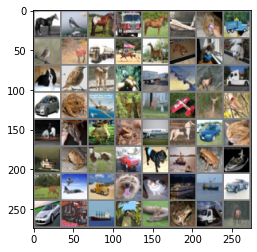

In [9]:
import matplotlib.pyplot as plt
import numpy as np
# 이미지를 보여주기 위한 함수

def imshow(img):
    img = 0.5*img  + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
#print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Define CNN

In [10]:
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal(m.weight.data)
        torch.nn.init.ones_(m.bias.data)
        
def Conv2d_dw(ch_in,ch_out):
    return nn.Sequential(
        # depth wise conv (step1)
        nn.Conv2d(ch_in,ch_in,3,1,1,groups=ch_in),
        nn.BatchNorm2d(ch_in),
        nn.ReLU(),

        #point wise conv
        nn.Conv2d(ch_in,ch_out,1,1,0),
        nn.BatchNorm2d(ch_out),
        nn.ReLU()
    )
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5,stride=1,padding=1)
        self.conv2 = Conv2d_dw(32, 64)
        self.conv3 = Conv2d_dw(64, 128)
        self.batchn1 = nn.BatchNorm2d(32)
        self.batchn2 = nn.BatchNorm2d(64)
        self.batchn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, stride=2,padding=0) 
        self.dropout = nn.Dropout(0.5)
    
        self.fc1 = nn.Linear(128*3*3, 500)
        self.fc2 = nn.Linear(500,10)


    def forward(self, x):
        x = self.pool(F.relu(self.batchn1(self.conv1(x))))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        #x = self.pool(F.relu(self.dropout(self.conv1(x))))
        #x = self.pool(F.relu(self.dropout(self.conv2(x))))
        #x = self.pool(F.relu(self.dropout(self.conv3(x))))
        #print(x.shape)
        x = x.view(x.size(0),-1)
        
        x = self.dropout(self.fc1(x))
        x = self.dropout(self.fc2(x))
        return F.log_softmax(x,dim=1)

model=Model()
model.apply(weights_init)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  if __name__ == '__main__':


Model(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (batchn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

In [11]:
print("Model's state_dict:\n")
for param_tensor in model.state_dict():
    print(param_tensor, "\t ", model.state_dict()[param_tensor].size())

Model's state_dict:

conv1.weight 	  torch.Size([32, 3, 5, 5])
conv1.bias 	  torch.Size([32])
conv2.0.weight 	  torch.Size([32, 1, 3, 3])
conv2.0.bias 	  torch.Size([32])
conv2.1.weight 	  torch.Size([32])
conv2.1.bias 	  torch.Size([32])
conv2.1.running_mean 	  torch.Size([32])
conv2.1.running_var 	  torch.Size([32])
conv2.1.num_batches_tracked 	  torch.Size([])
conv2.3.weight 	  torch.Size([64, 32, 1, 1])
conv2.3.bias 	  torch.Size([64])
conv2.4.weight 	  torch.Size([64])
conv2.4.bias 	  torch.Size([64])
conv2.4.running_mean 	  torch.Size([64])
conv2.4.running_var 	  torch.Size([64])
conv2.4.num_batches_tracked 	  torch.Size([])
conv3.0.weight 	  torch.Size([64, 1, 3, 3])
conv3.0.bias 	  torch.Size([64])
conv3.1.weight 	  torch.Size([64])
conv3.1.bias 	  torch.Size([64])
conv3.1.running_mean 	  torch.Size([64])
conv3.1.running_var 	  torch.Size([64])
conv3.1.num_batches_tracked 	  torch.Size([])
conv3.3.weight 	  torch.Size([128, 64, 1, 1])
conv3.3.bias 	  torch.Size([128])
conv3.4.w

In [12]:
from torchsummary import summary
summary(model.to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]           2,432
       BatchNorm2d-2           [-1, 32, 30, 30]              64
         MaxPool2d-3           [-1, 32, 15, 15]               0
            Conv2d-4           [-1, 32, 15, 15]             320
       BatchNorm2d-5           [-1, 32, 15, 15]              64
              ReLU-6           [-1, 32, 15, 15]               0
            Conv2d-7           [-1, 64, 15, 15]           2,112
       BatchNorm2d-8           [-1, 64, 15, 15]             128
              ReLU-9           [-1, 64, 15, 15]               0
        MaxPool2d-10             [-1, 64, 7, 7]               0
           Conv2d-11             [-1, 64, 7, 7]             640
      BatchNorm2d-12             [-1, 64, 7, 7]             128
             ReLU-13             [-1, 64, 7, 7]               0
           Conv2d-14            [-1, 12

# Loss & Optimizer

In [13]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.MultiStepLR(optimizer=optimizer,
                milestones=[2,5, 10, 11, 28, 33], gamma=0.5)

In [14]:
type(trainloader)

torch.utils.data.dataloader.DataLoader

In [15]:
type(validloader)

torch.utils.data.dataloader.DataLoader

# Train & Validation

In [16]:
train_loss=[]
train_acc=[]
val_loss=[]
val_acc=[]

num_epochs = 200

model.to(device)
for epoch in range(num_epochs):
    print('epoch : ',epoch+1)
    model.train() 
    for i, data in enumerate(trainloader, 0):

        inputs = data[0].to(device)
        labels = data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        scheduler.step()
        
    model.eval()  
    with torch.no_grad():
        running_loss = 0.0
        corrects = 0.0
        total = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs = data[0].to(device)
            labels = data[1].to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            total += labels.size(0)
            corrects += (preds == labels).sum().item()

        epoch_loss = running_loss / i
        epoch_acc = 100*corrects/total
        train_loss.append(epoch_loss)
        train_acc.append(100*corrects/total)
        print('-' * 10)
        print('train: Loss: {:.4f} Acc: {:.4f}'.format(
            epoch_loss, epoch_acc))
        
        running_loss = 0.0
        corrects = 0.0
        total = 0.0
        for i, data in enumerate(validloader, 0):
            inputs = data[0].to(device)
            labels = data[1].to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            total += labels.size(0)
            corrects += (preds == labels).sum().item()  

        epoch_loss = running_loss / i
        epoch_acc = 100*corrects/total
        val_loss.append(epoch_loss)
        val_acc.append(epoch_acc)

        print('valid:  Loss: {:.4f} Acc: {:.4f}'.format(
        epoch_loss, epoch_acc))
        print('-' * 10,'\n')

epoch :  1
----------
train: Loss: 1.9333 Acc: 35.8925
valid:  Loss: 1.9423 Acc: 35.5500
---------- 

epoch :  2
----------
train: Loss: 1.8390 Acc: 40.0275
valid:  Loss: 1.8496 Acc: 39.7000
---------- 

epoch :  3
----------
train: Loss: 1.7769 Acc: 43.3175
valid:  Loss: 1.7890 Acc: 42.1400
---------- 

epoch :  4
----------
train: Loss: 1.7334 Acc: 45.1650
valid:  Loss: 1.7476 Acc: 44.1500
---------- 

epoch :  5
----------
train: Loss: 1.7023 Acc: 46.8150
valid:  Loss: 1.7175 Acc: 45.5000
---------- 

epoch :  6
----------
train: Loss: 1.6752 Acc: 47.9950
valid:  Loss: 1.6909 Acc: 46.2500
---------- 

epoch :  7
----------
train: Loss: 1.6541 Acc: 48.4700
valid:  Loss: 1.6696 Acc: 47.4700
---------- 

epoch :  8
----------
train: Loss: 1.6355 Acc: 49.6775
valid:  Loss: 1.6515 Acc: 48.7800
---------- 

epoch :  9
----------
train: Loss: 1.6221 Acc: 50.1075
valid:  Loss: 1.6380 Acc: 49.2700
---------- 

epoch :  10
----------
train: Loss: 1.6130 Acc: 50.9150
valid:  Loss: 1.6305 Acc: 

----------
train: Loss: 1.2743 Acc: 64.7375
valid:  Loss: 1.3144 Acc: 62.0400
---------- 

epoch :  82
----------
train: Loss: 1.2680 Acc: 64.7675
valid:  Loss: 1.3088 Acc: 62.1100
---------- 

epoch :  83
----------
train: Loss: 1.2637 Acc: 64.6525
valid:  Loss: 1.3035 Acc: 62.0100
---------- 

epoch :  84
----------
train: Loss: 1.2585 Acc: 64.8425
valid:  Loss: 1.2995 Acc: 62.2700
---------- 

epoch :  85
----------
train: Loss: 1.2555 Acc: 64.8400
valid:  Loss: 1.2958 Acc: 62.4700
---------- 

epoch :  86
----------
train: Loss: 1.2590 Acc: 65.1450
valid:  Loss: 1.2996 Acc: 62.5500
---------- 

epoch :  87
----------
train: Loss: 1.2504 Acc: 65.0150
valid:  Loss: 1.2920 Acc: 62.4300
---------- 

epoch :  88
----------
train: Loss: 1.2515 Acc: 65.3075
valid:  Loss: 1.2934 Acc: 62.4000
---------- 

epoch :  89
----------
train: Loss: 1.2486 Acc: 65.0525
valid:  Loss: 1.2910 Acc: 62.3600
---------- 

epoch :  90
----------
train: Loss: 1.2406 Acc: 65.4750
valid:  Loss: 1.2837 Acc: 62.

----------
train: Loss: 1.1174 Acc: 69.0950
valid:  Loss: 1.1722 Acc: 65.8600
---------- 

epoch :  161
----------
train: Loss: 1.1113 Acc: 69.2850
valid:  Loss: 1.1654 Acc: 65.7700
---------- 

epoch :  162
----------
train: Loss: 1.1091 Acc: 69.0075
valid:  Loss: 1.1635 Acc: 65.5800
---------- 

epoch :  163
----------
train: Loss: 1.1108 Acc: 69.2125
valid:  Loss: 1.1658 Acc: 65.6200
---------- 

epoch :  164
----------
train: Loss: 1.1073 Acc: 69.2025
valid:  Loss: 1.1630 Acc: 65.7300
---------- 

epoch :  165
----------
train: Loss: 1.1074 Acc: 69.3125
valid:  Loss: 1.1646 Acc: 65.6900
---------- 

epoch :  166
----------
train: Loss: 1.1044 Acc: 69.2725
valid:  Loss: 1.1610 Acc: 65.9400
---------- 

epoch :  167
----------
train: Loss: 1.1113 Acc: 69.3200
valid:  Loss: 1.1654 Acc: 65.8100
---------- 

epoch :  168
----------
train: Loss: 1.1078 Acc: 69.5050
valid:  Loss: 1.1633 Acc: 65.9400
---------- 

epoch :  169
----------
train: Loss: 1.1056 Acc: 69.5525
valid:  Loss: 1.1625

In [17]:
# blue for train
# darkgreen for validation
# crimson for test

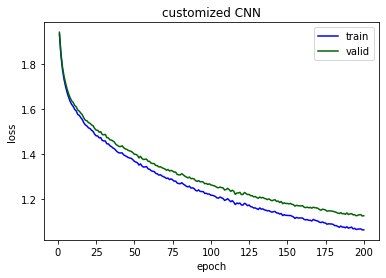

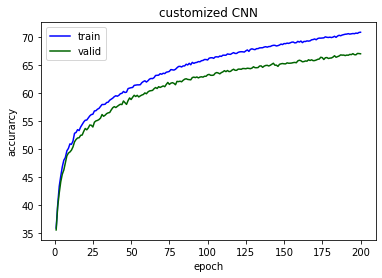

In [18]:
x_axis = range(1,num_epochs+1)

#plot loss
plt.plot(x_axis,train_loss,'blue')
plt.plot(x_axis,val_loss,'darkgreen') 
plt.legend(('train', 'valid'),loc='upper right')
plt.title('customized CNN')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#plot accuracy
plt.plot(x_axis,train_acc,'blue')
plt.plot(x_axis,val_acc,'darkgreen')
plt.legend(('train', 'valid'),loc='upper left')
plt.title('customized CNN')
plt.xlabel('epoch')
plt.ylabel('accurarcy')
plt.show()

# Train & Test

In [19]:
# train_loss=[]
# train_acc=[]
# test_loss=[]
# test_acc=[]

# num_epochs = 200

# model.to(device)
# for epoch in range(num_epochs):
#     print('epoch : ',epoch+1)
#     model.train() 
#     for i, data in enumerate(trainloader, 0):

#         inputs = data[0].to(device)
#         labels = data[1].to(device)

#         optimizer.zero_grad()

#         outputs = model(inputs)
#         _, preds = torch.max(outputs, 1)
#         loss = criterion(outputs, labels)

#         loss.backward()
#         optimizer.step()
#         scheduler.step()
        
#     model.eval()  
#     with torch.no_grad():
#         running_loss = 0.0
#         corrects = 0.0
#         total = 0.0
#         for i, data in enumerate(trainloader, 0):
#             inputs = data[0].to(device)
#             labels = data[1].to(device)

#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)
#             loss = criterion(outputs, labels)

#             running_loss += loss.item()
#             total += labels.size(0)
#             corrects += (preds == labels).sum().item()

#         epoch_loss = running_loss / i
#         epoch_acc = 100*corrects/total
#         train_loss.append(epoch_loss)
#         train_acc.append(100*corrects/total)
#         print('-' * 10)
#         print('train: Loss: {:.4f} Acc: {:.4f}'.format(
#             epoch_loss, epoch_acc))
        
#         running_loss = 0.0
#         corrects = 0.0
#         total = 0.0
#         for i, data in enumerate(testloader, 0):
#             inputs = data[0].to(device)
#             labels = data[1].to(device)
            
#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)
#             loss = criterion(outputs, labels)

#             running_loss += loss.item()
#             total += labels.size(0)
#             corrects += (preds == labels).sum().item()  

#         epoch_loss = running_loss / i
#         epoch_acc = 100*corrects/total
#         test_loss.append(epoch_loss)
#         test_acc.append(epoch_acc)

#         print('test:  Loss: {:.4f} Acc: {:.4f}'.format(
#         epoch_loss, epoch_acc))
#         print('-' * 10,'\n')

In [20]:
# x_axis = range(1,num_epochs+1)

# #plot loss
# plt.plot(x_axis,train_loss,'blue')
# plt.plot(x_axis,test_loss,'crimson') 
# plt.legend(('train', 'test'),loc='upper right')
# plt.title('customized CNN')
# plt.xlabel('epoch')
# plt.ylabel('loss')
# plt.show()

# #plot accuracy
# plt.plot(x_axis,train_acc,'blue')
# plt.plot(x_axis,test_acc,'crimson')
# plt.legend(('train', 'test'),loc='upper left')
# plt.title('customized CNN')
# plt.xlabel('epoch')
# plt.ylabel('accurarcy')
# plt.show()